# Análisis Comparativo de Modelos Clásicos y Redes Neuronales en la Predicción de Precios y Volatilidad del S&P 500

## Introducción

Los mercados financieros son altamente dinámicos y están influenciados por diversos factores económicos, sociales y políticos. La predicción precisa de precios y volatilidad de índices clave, como el S&P 500, es crucial para:

- Gestión de riesgos: Identificar periodos de alta volatilidad para ajustar estrategias de inversión.
- Toma de decisiones estratégicas: Anticipar tendencias para optimizar compras o ventas de activos.
- Evaluación de estrategias automatizadas: Crear algoritmos robustos que integren modelos clásicos y modernos.

El proyecto se enfocará en desarrollar y comparar modelos clásicos (ARIMA y GARCH) y redes neuronales (como LSTM y MLP) para responder preguntas clave relacionadas con precios y volatilidad.

## Pregunta clave

¿Cómo podemos predecir de manera efectiva los movimientos del S&P 500 y su volatilidad diaria para optimizar estrategias de inversión y gestión de riesgos, y qué modelo ofrece mayor valor predictivo?

## Objetivos

- Predicción de precios diarios: Estimar el precio de cierre del S&P 500 para los próximos días.
- Predicción de la volatilidad: Calcular y predecir la volatilidad diaria para evaluar el riesgo asociado.
- Comparación de modelos: Evaluar la precisión y el comportamiento de modelos clásicos (ARIMA, GARCH) versus redes neuronales (LSTM, MLP).
- Valor agregado: Identificar cómo las predicciones mejoran la toma de decisiones en estrategias de inversión y gestión del riesgo.

## Extracción de datos
Fuente: Yahoo Finance (^GSPC) para datos del S&P 500 con una frecuencia diaria, desde 1990-01-01 hasta la fecha.

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller

In [2]:
# Descargar datos del S&P 500 desde Yahoo Finance
ticker = '^GSPC'  # Símbolo para el S&P 500
data = yf.download(ticker, start='1990-01-01', end='2023-12-31')

# Seleccionar solo la columna de precios ajustados y renombrarla
data = data[['Adj Close']]
data.rename(columns={'Adj Close': 'Price'}, inplace=True)

# Mostrar las primeras filas del DataFrame para confirmar la estructura
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price            Price
Ticker           ^GSPC
Date                  
1990-01-02  359.690002
1990-01-03  358.760010
1990-01-04  355.670013
1990-01-05  352.200012
1990-01-08  353.790009


## Análisis descriptivo
### Análsiis descriptivo serie original

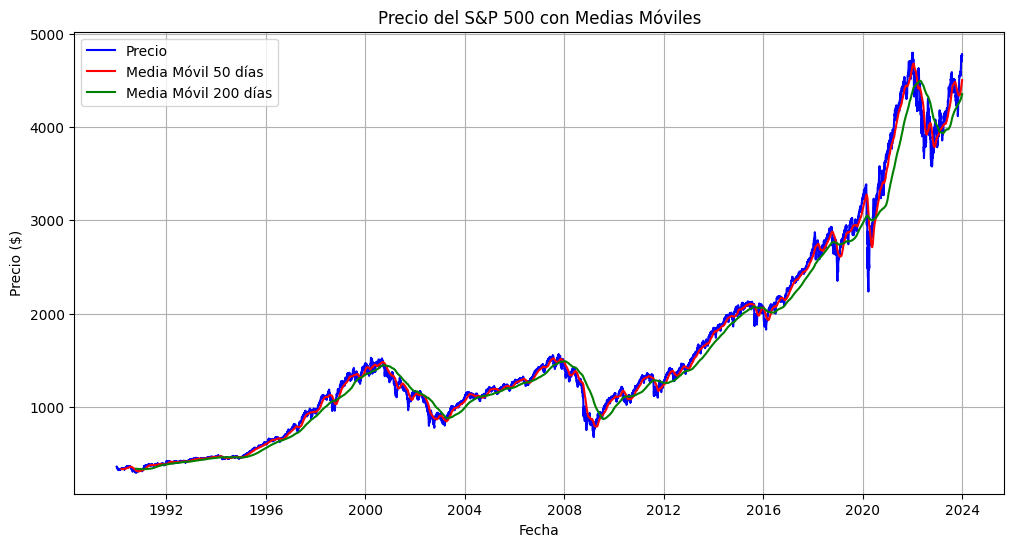

In [3]:
# Calcular medias móviles de 50 y 200 días
data['SMA_50'] = data['Price'].rolling(window=50).mean()
data['SMA_200'] = data['Price'].rolling(window=200).mean()

# Gráfico de precios con las medias móviles
plt.figure(figsize=(12, 6))
plt.plot(data['Price'], label='Precio', color='blue')
plt.plot(data['SMA_50'], label='Media Móvil 50 días', color='red')
plt.plot(data['SMA_200'], label='Media Móvil 200 días', color='green')
plt.title('Precio del S&P 500 con Medias Móviles')
plt.xlabel('Fecha')
plt.ylabel('Precio ($)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Resumen estadístico de la serie de precios
price_stats = data['Price'].describe()
print(price_stats)

Ticker        ^GSPC
count   8565.000000
mean    1583.898693
std     1089.516200
min      295.459991
25%      896.140015
50%     1267.650024
75%     2049.800049
max     4796.560059


- Se observa una tendencia alcista a largo plazo con periodos de volatilidad.
- Las caídas significativas durante eventos como la burbuja de las puntocom (2000) y la crisis financiera de 2008 son evidentes en el gráfico de la serie.
- Se observa cómo después de cada período de caída existen recuperaciones y nuevos máximos históricos.
- El precio máximo histórico es de 4796.56 usd y el mínimo es de 295.46 usd, con un promedio histórico de 1583.90 usd y una desviación estándar de 1089.52 usd.
- Al comparar el promedio histórico con la desviación estándar, se observa la volatilidad propia de las series accionarias.
- Cuando la media móvil de 50 períodos cruza por encima de la media móvil de 200 períodos suele indicar una señal alcista (Golden Cross), y viceversa para una señal bajista (Death Cross). Este comportamiento se puede observar en el gráfico.

In [5]:
# Realizar la prueba de Dickey-Fuller aumentada (ADF)
result = adfuller(data['Price'].dropna())
print('Estadístico ADF:', result[0])
print('Valor p:', result[1])
print('Valores Críticos:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

Estadístico ADF: 1.6760444037084234
Valor p: 0.998068693758538
Valores Críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


- Recordemos que la hipótesis nula de la prueba es que la serie tiene una raíz unitaria, es decir, la serie es no estacionaria, dado que se tiene un valor p muy alto, se concluye que existe la necesidad de diferenciar o transformar la serie para modelado, se calculan entonces los log retornos de la serie.

### Análisis descriptivo de los log retornos

In [6]:
# Calcular los log retornos diarios
data['Log_Returns'] = np.log(data['Price'] / data['Price'].shift(1))
data.dropna(inplace=True)  # Eliminar valores nulos causados por el shift

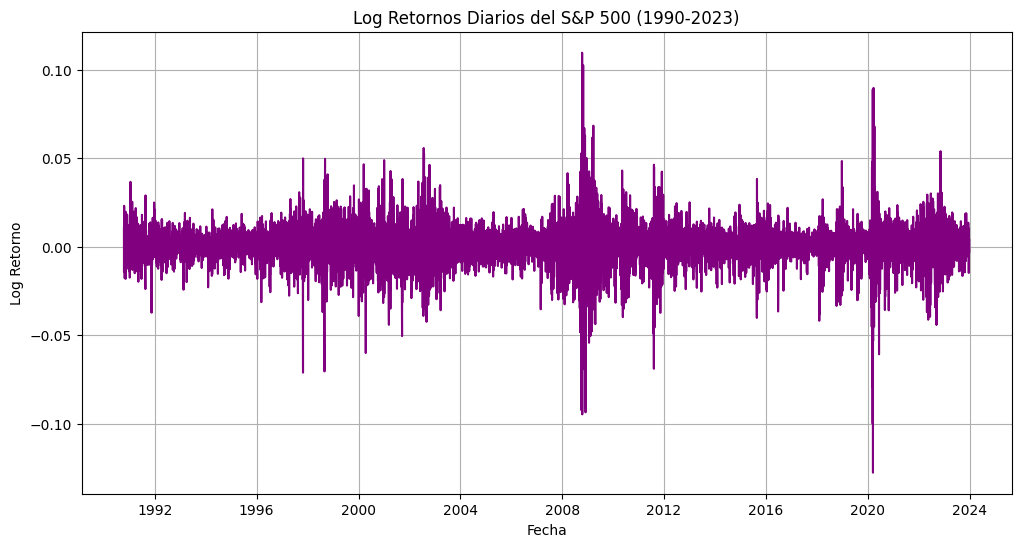

In [7]:
# Gráfico de los log retornos
plt.figure(figsize=(12, 6))
plt.plot(data['Log_Returns'], color='purple')
plt.title('Log Retornos Diarios del S&P 500 (1990-2023)')
plt.xlabel('Fecha')
plt.ylabel('Log Retorno')
plt.grid(True)
plt.show()

- Se puede observar en la serie histórica de log retornos cómo existen períodos con alta volatilidad y otros en los que el cambio en el precio no es tan drástico.
- Es evidente cómo las perturbaciones de la serie más grandes se encuentran justamente en eventos económicos y sociales significativos, como es el caso de la crisis del 2008 y la pandemia.
- La serie sin embargo ya no muestra tendencia y parece ser estacionaria.

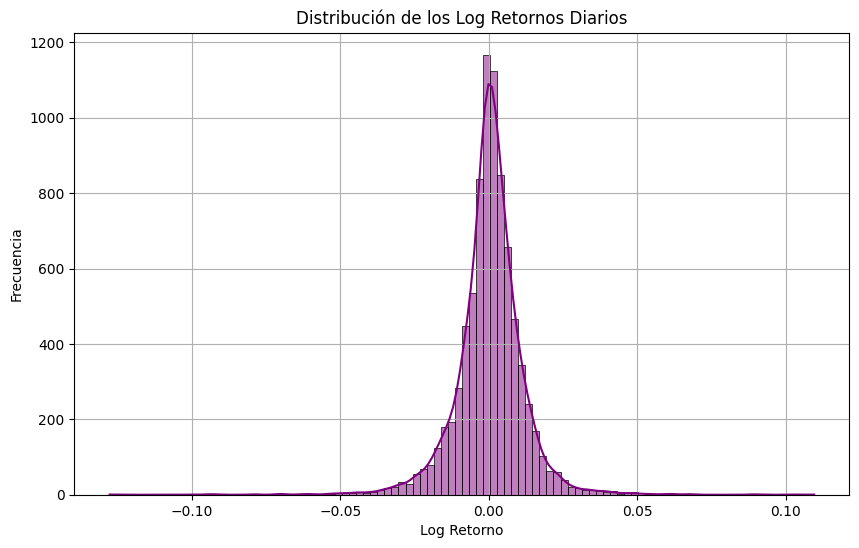

In [8]:
# Histograma de los log retornos
plt.figure(figsize=(10, 6))
sns.histplot(data['Log_Returns'], bins=100, kde=True, color='purple')
plt.title('Distribución de los Log Retornos Diarios')
plt.xlabel('Log Retorno')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [9]:
# Resumen estadístico de los log retornos
returns_stats = data['Log_Returns'].describe()
print(returns_stats)

# Calcular sesgo (Skewness) y curtosis (Kurtosis)
skewness = skew(data['Log_Returns'])
kurt = kurtosis(data['Log_Returns'])
print(f'Sesgo (Skewness): {skewness:.4f}')
print(f'Curtosis: {kurt:.4f}')

count    8366.000000
mean        0.000331
std         0.011490
min        -0.127652
25%        -0.004464
50%         0.000563
75%         0.005708
max         0.109572
Name: Log_Returns, dtype: float64
Sesgo (Skewness): -0.3982
Curtosis: 10.7525


- El sesgo y, principalmente, la curtosis de la distribución de los retornos son evidencia clara de que no son normales, sin embargo su distribución es bastante simétrica.
- El histograma permite ver que la distribución de los datos tiene colas pesadas y picos estrechos, esto es tun comportamiento típico de series financieras.

In [10]:
# Realizar la prueba de Dickey-Fuller aumentada (ADF) para los log retornos
result = adfuller(data['Log_Returns'])
print('Estadístico ADF:', result[0])
print('Valor p:', result[1])
print('Valores Críticos:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

Estadístico ADF: -16.87605454533426
Valor p: 1.071870623527135e-29
Valores Críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Tal como lo habíamos anticipado, el valor p de la prueba de estacionariedad es muy pequeño y, por consiguiente, se puede concluir que la serie es estacionaria. Esto implica que se puede realizar el modelado de la serie con metodologías como ARIMA.

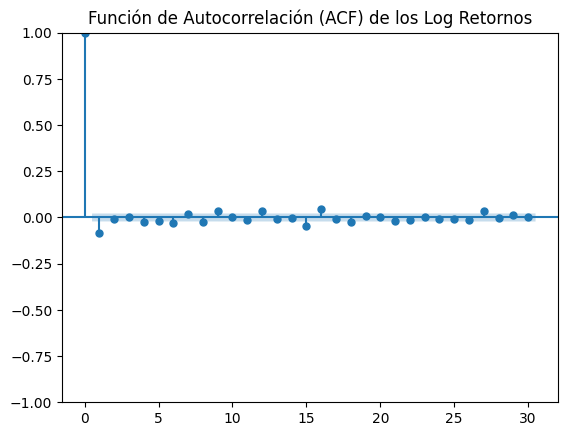

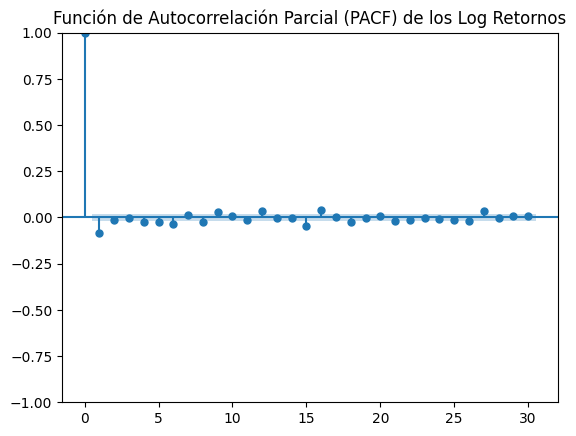

In [11]:
# Función de autocorrelación (ACF) para los log retornos
plot_acf(data['Log_Returns'], lags=30)
plt.title('Función de Autocorrelación (ACF) de los Log Retornos')
plt.show()

# Función de autocorrelación parcial (PACF) para los log retornos
plot_pacf(data['Log_Returns'], lags=30)
plt.title('Función de Autocorrelación Parcial (PACF) de los Log Retornos')
plt.show()

En los gráficos de autocorrelación y autocorrelación parcial no se observan rezagos altamente significativos, sin embargo, un ACF de los retornos al cuadrado puede mostrar autocorrelación significativa siendo esto evidencia de volatilidad agrupada.

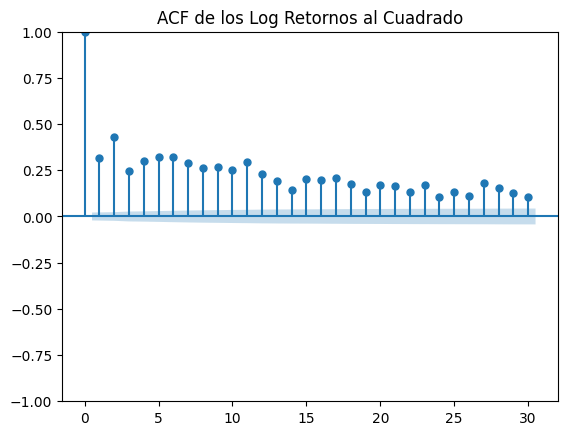

In [12]:
# Función de autocorrelación para los log retornos al cuadrado
plot_acf(data['Log_Returns']**2, lags=30)
plt.title('ACF de los Log Retornos al Cuadrado')
plt.show()

- La autocorrelación significativa en los retornos al cuadrado sugiere que periodos de alta volatilidad tienden a seguir a otros de alta volatilidad.
- El uso de modelos Garch podría ser más adecuado ya que estos capturan la heterocedasticidad condicional presente en los datos financieros.

## Modelado

Ahora que se ha realizado el análisis descriptivo de la serie de precios y los log retornos del S&P 500, se modelará la serie utilizando cuatro metodologías diferentes:
- ARIMA
- GARCH
- LSTM
- MLP

In [101]:
# Librerías para modelado
from pmdarima.arima import auto_arima
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import math

# Librerías para redes neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

### Preparación de los datos

In [14]:
# Total de observaciones
total_obs = len(data)

# Índices para dividir los datos
train_size = int(total_obs * 0.8)
validation_size = int(total_obs * 0.1)
test_size = total_obs - train_size - validation_size

# División de los datos
train_data = data['Log_Returns'].iloc[:train_size]
validation_data = data['Log_Returns'].iloc[train_size:train_size + validation_size]
test_data = data['Log_Returns'].iloc[train_size + validation_size:]

# Confirmar tamaños
print(f'Tamaño de entrenamiento: {len(train_data)}')
print(f'Tamaño de validación: {len(validation_data)}')
print(f'Tamaño de prueba: {len(test_data)}')


Tamaño de entrenamiento: 6692
Tamaño de validación: 836
Tamaño de prueba: 838


### ARIMA

Para encontrar el mejor modelo arima aproximado, se utilizará la función auto.arima basado en el criterio de AIC

In [15]:
# Encontrar el mejor modelo ARIMA
arima_model = auto_arima(train_data,
                         start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         seasonal=False,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-41117.199, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-41086.268, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-41106.325, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-41108.300, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-41115.237, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-41115.678, Time=0.37 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-41117.580, Time=0.35 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-41115.504, Time=0.41 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-41113.907, Time=1.87 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-41121.969, Time=0.76 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-41112.144, Time=0.60 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-41120.247, Time=0.92 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-41119.906, Time=0.91 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-41122.154, Time=0.90 sec
 ARIM

In [16]:
# Predecir en el conjunto de validación
n_validation = len(validation_data)
arima_pred_val = arima_model.predict(n_periods=n_validation)

# Calcular métricas en validación
rmse_arima_val = math.sqrt(mean_squared_error(validation_data, arima_pred_val))
mae_arima_val = mean_absolute_error(validation_data, arima_pred_val)

print(f'ARIMA - RMSE Validación: {rmse_arima_val:.6f}')
print(f'ARIMA - MAE Validación: {mae_arima_val:.6f}')

ARIMA - RMSE Validación: 0.013672
ARIMA - MAE Validación: 0.007664


i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [17]:
# Concatenar entrenamiento y validación
train_val_data = pd.concat([train_data, validation_data])

# Reentrenar el modelo ARIMA
arima_model.update(train_val_data)

# Predecir en el conjunto de prueba
n_test = len(test_data)
arima_pred_test = arima_model.predict(n_periods=n_test)

# Calcular métricas en prueba
rmse_arima_test = math.sqrt(mean_squared_error(test_data, arima_pred_test))
mae_arima_test = mean_absolute_error(test_data, arima_pred_test)

print(f'ARIMA - RMSE Prueba: {rmse_arima_test:.6f}')
print(f'ARIMA - MAE Prueba: {mae_arima_test:.6f}')

ARIMA - RMSE Prueba: 0.011161
ARIMA - MAE Prueba: 0.008323


### GARCH

Se probarán diferentes combinaciones de órdenes (p, q), seleccionando el modelo con el menor AIC.

In [18]:
# Rescalar los log retornos multiplicándolos por 100
train_data_scaled = train_data * 100
validation_data_scaled = validation_data * 100
test_data_scaled = test_data * 100

# Buscar el mejor modelo GARCH con datos rescalados
best_aic = np.inf
best_order = None
best_model = None

for p in range(1, 5):
    for q in range(1, 5):
        try:
            tmp_model = arch_model(train_data_scaled, vol='Garch', p=p, q=q, rescale=False)
            tmp_res = tmp_model.fit(disp='off')
            if tmp_res.aic < best_aic:
                best_aic = tmp_res.aic
                best_order = (p, q)
                best_model = tmp_res
        except Exception as e:
            # Imprimir el error si ocurre
            print(f'Error al ajustar GARCH({p},{q}): {e}')
            continue

print(f'Mejor modelo GARCH orden: p={best_order[0]}, q={best_order[1]} con AIC={best_aic}')

Mejor modelo GARCH orden: p=2, q=2 con AIC=17723.71046316779


In [19]:
# Predecir la volatilidad en el conjunto de validación
garch_forecast_val = best_model.forecast(horizon=len(validation_data_scaled), reindex=False)
garch_pred_val = garch_forecast_val.variance[-len(validation_data_scaled):]
garch_pred_val = garch_pred_val.values.flatten()

# Calcular los retornos al cuadrado (varianza real)
validation_data_variance = validation_data_scaled.values.flatten() ** 2

# Calcular métricas en validación
rmse_garch_val = math.sqrt(mean_squared_error(validation_data_variance, garch_pred_val))
mae_garch_val = mean_absolute_error(validation_data_variance, garch_pred_val)

print(f'GARCH - RMSE Validación: {rmse_garch_val:.6f}')
print(f'GARCH - MAE Validación: {mae_garch_val:.6f}')

GARCH - RMSE Validación: 8.807539
GARCH - MAE Validación: 2.107445


In [ ]:
# Ajustar el modelo GARCH con un componente ARMA en la media
# Por ejemplo, un ARMA(1,1) en la media y un GARCH(p,q) en la varianza
p_order = best_order[0]  # Usando los órdenes p y q encontrados anteriormente
q_order = best_order[1]

# Definir el modelo con componente de media ARMA
garch_model = arch_model(train_data_scaled, mean='ARX', lags=1, vol='GARCH', p=p_order, q=q_order, rescale=False)

# Ajustar el modelo
garch_model_fit = garch_model.fit(update_freq=5, disp='off')

# Predecir los retornos en el conjunto de prueba
garch_forecast = garch_model_fit.forecast(horizon=len(test_data_scaled), reindex=False)
garch_pred_mean = garch_forecast.mean.values[-len(test_data_scaled):].flatten()

# Invertir el escalado de las predicciones
garch_pred_test = garch_pred_mean / 100  # Dividir por 100 para deshacer el escalado

# Valores reales
test_data_real = test_data.values

# Calcular las métricas de error
rmse_garch_test = math.sqrt(mean_squared_error(test_data_real, garch_pred_test))
mae_garch_test = mean_absolute_error(test_data_real, garch_pred_test)

print(f'GARCH - RMSE Prueba: {rmse_garch_test:.6f}')
print(f'GARCH - MAE Prueba: {mae_garch_test:.6f}')

GARCH - RMSE Prueba: 0.011162
GARCH - MAE Prueba: 0.008322


### LSTM

In [92]:
# Definir la longitud de la secuencia
seq_length = 60

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
train_data = data['Price'].values[:train_size]
val_data = data['Price'].values[train_size:train_size + validation_size]
test_data = data['Price'].values[train_size + validation_size:]

# Escalar los datos de entrenamiento
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))

# Escalar los datos de validación y prueba utilizando el mismo escalador ajustado con los datos de entrenamiento
val_scaled = scaler.transform(val_data.reshape(-1, 1))
test_scaled = scaler.transform(test_data.reshape(-1, 1))

# Crear secuencias para entrenamiento
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Crear datos de entrenamiento
X_train, y_train = create_sequences(train_scaled, seq_length)

# Crear datos de validación (agregamos seq_length al inicio para crear secuencias completas)
val_combined = np.concatenate((train_scaled[-seq_length:], val_scaled))
X_val, y_val = create_sequences(val_combined, seq_length)

# Crear datos de prueba (agregamos seq_length al inicio para crear secuencias completas)
test_combined = np.concatenate((val_scaled[-seq_length:], test_scaled))
X_test, y_test = create_sequences(test_combined, seq_length)


In [ ]:
# Definir el modelo LSTM
lstm_model = Sequential()

# Primera capa LSTM
lstm_model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())

# Segunda capa LSTM
lstm_model.add(LSTM(units=128, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())

# Tercera capa LSTM
lstm_model.add(LSTM(units=64))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())

# Capa densa intermedia
lstm_model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.001)))
lstm_model.add(Dropout(0.2))

# Capa de salida
lstm_model.add(Dense(1))

# Compilar el modelo con un optimizador ajustado
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entrenar el modelo
history = lstm_model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 0.7562 - val_loss: 0.4849
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.1514 - val_loss: 0.2991
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0895 - val_loss: 0.1328
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0606 - val_loss: 0.0842
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0478 - val_loss: 0.1030
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0400 - val_loss: 0.0996
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0347 - val_loss: 0.0961
Epoch 8/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0307 - val_loss: 0.0564
Epoch 9/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0271 - val_loss: 0.0796
Epoch 10/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0251 - val_loss: 0.0824
Epoch 11/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0219 - val_loss: 0.0491
Epoch 12/20
208/208 ━━━━━━━━━━

In [39]:
# Realizar predicciones en el conjunto de prueba
lstm_pred = lstm_model.predict(X_test)

# Invertir la escala
lstm_pred_inv = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular métricas en prueba
rmse_lstm_test = math.sqrt(mean_squared_error(y_test_inv, lstm_pred_inv))
mae_lstm_test = mean_absolute_error(y_test_inv, lstm_pred_inv)

print(f'LSTM - RMSE Prueba: {rmse_lstm_test:.6f}')
print(f'LSTM - MAE Prueba: {mae_lstm_test:.6f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
LSTM - RMSE Prueba: 1767.872544
LSTM - MAE Prueba: 1734.995932


### MLP

In [79]:
# Crear ventanas de tiempo (lag features)
def create_mlp_data(data, lag):
    X = []
    y = []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Definir el número de lags
lag = 10

# Crear conjuntos de entrenamiento
X_train_mlp, y_train_mlp = create_mlp_data(train_scaled, lag)

# Crear conjuntos de validación
# Concatenar los últimos 'lag' datos del conjunto de entrenamiento con el conjunto de validación
val_combined = np.concatenate((train_scaled[-lag:], val_scaled))
X_val_mlp, y_val_mlp = create_mlp_data(val_combined, lag)

# Crear conjuntos de prueba
# Concatenar los últimos 'lag' datos del conjunto de validación con el conjunto de prueba
test_combined = np.concatenate((val_scaled[-lag:], test_scaled))
X_test_mlp, y_test_mlp = create_mlp_data(test_combined, lag)

In [81]:
# Definir el modelo MLP
mlp_model = Sequential()

# Primera capa densa con regularización y BatchNormalization
mlp_model.add(Dense(256, input_dim=lag, kernel_regularizer=l2(0.001)))
mlp_model.add(BatchNormalization())
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.3))

# Segunda capa densa
mlp_model.add(Dense(128, kernel_regularizer=l2(0.001)))
mlp_model.add(BatchNormalization())
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.3))

# Tercera capa densa
mlp_model.add(Dense(64, kernel_regularizer=l2(0.001)))
mlp_model.add(BatchNormalization())
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.3))

# Cuarta capa densa
mlp_model.add(Dense(32, kernel_regularizer=l2(0.001)))
mlp_model.add(BatchNormalization())
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.3))

# Capa de salida
mlp_model.add(Dense(1))

# Compilar el modelo con un optimizador ajustado
optimizer = Adam(learning_rate=0.001)
mlp_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entrenar el modelo
history_mlp = mlp_model.fit(
    X_train_mlp, y_train_mlp,
    epochs=70,
    batch_size=64,
    validation_data=(X_val_mlp, y_val_mlp)
)

Epoch 1/70


i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2679 - val_loss: 1.1455
Epoch 2/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5662 - val_loss: 0.9154
Epoch 3/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4384 - val_loss: 0.7721
Epoch 4/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3763 - val_loss: 0.6419
Epoch 5/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3367 - val_loss: 0.5506
Epoch 6/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3065 - val_loss: 0.4558
Epoch 7/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2833 - val_loss: 0.4206
Epoch 8/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2609 - val_loss: 0.3354
Epoch 9/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2435 - val_loss: 0.2796
Epoch 10/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2252 - val_loss: 0.2636
Epoch 11/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2089 - val_loss: 0.2555
Epoch 12/70
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [82]:
# Realizar predicciones en el conjunto de prueba
mlp_pred = mlp_model.predict(X_test_mlp)

# Invertir la escala
mlp_pred_inv = scaler.inverse_transform(mlp_pred)
y_test_mlp_inv = scaler.inverse_transform(y_test_mlp.reshape(-1, 1))

# Calcular métricas en prueba
rmse_mlp_test = math.sqrt(mean_squared_error(y_test_mlp_inv, mlp_pred_inv))
mae_mlp_test = mean_absolute_error(y_test_mlp_inv, mlp_pred_inv)

print(f'MLP - RMSE Prueba: {rmse_mlp_test:.6f}')
print(f'MLP - MAE Prueba: {mae_mlp_test:.6f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP - RMSE Prueba: 555.099296
MLP - MAE Prueba: 549.837907


## Resultados

### Predicción de precios modelo ARIMA

In [102]:
# Usar el mejor orden (p,d,q) encontrado previamente
p, d, q = arima_model.order  # Extraer el orden del modelo ajustado previamente

# Inicializar la historia con los datos de entrenamiento
history = train_data.copy()

# Lista para almacenar las predicciones
predictions = []

# Realizar predicciones recursivas en el conjunto de validación
for t in range(len(validation_data)):
    # Ajustar el modelo ARIMA al historial actual
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    # Predecir el siguiente retorno logarítmico
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # Agregar el valor predicho al historial
    history = history.append(pd.Series(yhat, index=[validation_data.index[t]]))

# Reconstruir la serie de precios a partir del último precio de entrenamiento
last_train_price = data['Price'].iloc[train_size - 1]

# Lista para almacenar los precios pronosticados
predicted_prices = [last_train_price]

# Iterar sobre los retornos logarítmicos predichos para reconstruir los precios
for log_return in predictions:
    next_price = predicted_prices[-1] * np.exp(log_return)
    predicted_prices.append(next_price)

# Eliminar el primer precio que corresponde al último precio de entrenamiento
predicted_prices = predicted_prices[1:]

# Crear una serie de tiempo con los precios pronosticados y asignar las fechas correspondientes
predicted_prices_series = pd.Series(predicted_prices, index=validation_data.index)

# Obtener los precios reales del conjunto de validación
actual_prices_validation = data['Price'].iloc[train_size:train_size + validation_size]

# Calcular las métricas de error en la serie de precios
rmse_price_arima_val = math.sqrt(mean_squared_error(actual_prices_validation, predicted_prices_series))
mae_price_arima_val = mean_absolute_error(actual_prices_validation, predicted_prices_series)

print(f'ARIMA - RMSE Precio Validación: {rmse_price_arima_val:.6f}')
print(f'ARIMA - MAE Precio Validación: {mae_price_arima_val:.6f}')

# Graficar los precios reales vs. los pronosticados
plt.figure(figsize=(12,6))
plt.plot(actual_prices_validation, label='Precio Real')
plt.plot(predicted_prices_series, label='Precio Pronosticado (ARIMA)', linestyle='--')
plt.legend()
plt.title('Comparación de Precios Reales y Pronosticados - ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'append'

i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
i:\Mi unidad\Estudio\UniAndes\Semestre_3\Modelos avanzados 2\modelos_avanzados_deep_learning\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
i:\Mi unidad\Estudio\UniA

GARCH - RMSE Precio Validación: 383.464759
GARCH - MAE Precio Validación: 279.431135


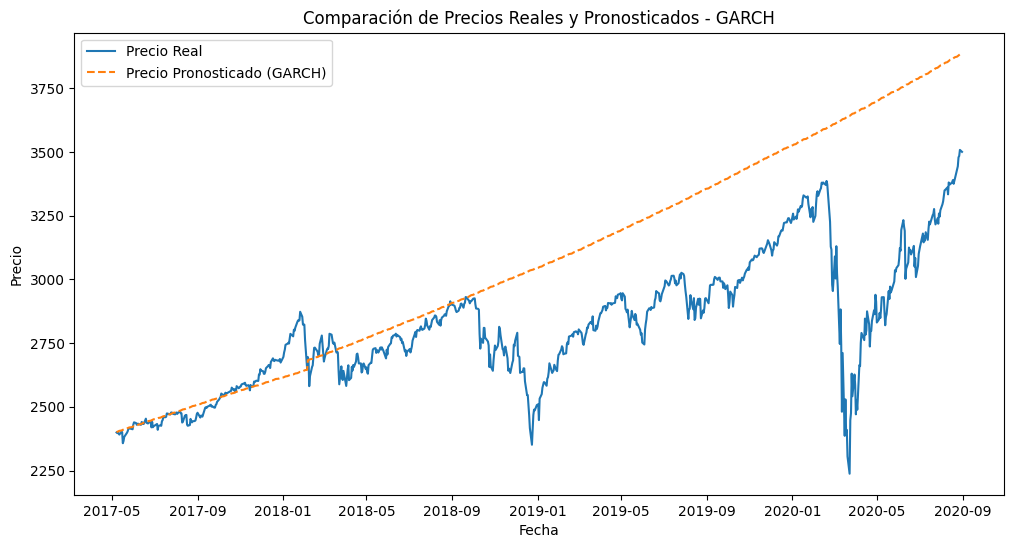

In [100]:
# Reconstrucción de la serie de precios para el modelo GARCH en los datos de validación

# Inicializar una lista para almacenar los retornos escalados (multiplicados por 100)
history_scaled = list(train_data_scaled)

# Lista para almacenar las predicciones de retornos escalados
garch_pred_scaled_returns = []

# Realizar predicciones recursivas en el conjunto de validación
for t in range(len(validation_data_scaled)):
    # Ajustar el modelo GARCH en el historial
    model = arch_model(history_scaled, mean='ARX', lags=1, vol='GARCH', p=p_order, q=q_order, rescale=False)
    model_fit = model.fit(disp='off')
    
    # Predecir el siguiente retorno
    forecast = model_fit.forecast(horizon=1, reindex=False)
    yhat = forecast.mean.values[-1, 0]
    garch_pred_scaled_returns.append(yhat)
    
    # Agregar el retorno predicho al historial para futuras predicciones
    history_scaled.append(yhat)

# Desescalar las predicciones de retornos
garch_pred_returns = np.array(garch_pred_scaled_returns) / 100  # Dividir por 100 para deshacer el escalado

# Reconstruir los precios a partir del último precio de entrenamiento
garch_pred_prices = [last_train_price]

# Iterar sobre los retornos predichos para reconstruir los precios
for ret in garch_pred_returns:
    next_price = garch_pred_prices[-1] * np.exp(ret)
    garch_pred_prices.append(next_price)

# Eliminar el primer precio que corresponde al último precio de entrenamiento
garch_pred_prices = garch_pred_prices[1:]

# Crear una serie de tiempo con los precios pronosticados y asignar las fechas correspondientes
garch_pred_prices_series = pd.Series(garch_pred_prices, index=validation_dates)

# Calcular las métricas de error en la serie de precios
rmse_price_garch_val = math.sqrt(mean_squared_error(actual_prices_validation, garch_pred_prices_series))
mae_price_garch_val = mean_absolute_error(actual_prices_validation, garch_pred_prices_series)

print(f'GARCH - RMSE Precio Validación: {rmse_price_garch_val:.6f}')
print(f'GARCH - MAE Precio Validación: {mae_price_garch_val:.6f}')

# Graficar los precios reales vs. los pronosticados
plt.figure(figsize=(12,6))
plt.plot(actual_prices_validation, label='Precio Real')
plt.plot(garch_pred_prices_series, label='Precio Pronosticado (GARCH)', linestyle='--')
plt.legend()
plt.title('Comparación de Precios Reales y Pronosticados - GARCH')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()

In [83]:
# Precio inicial para comenzar la predicción (último precio del conjunto de entrenamiento)
initial_price_arima = data['Price'].iloc[train_size + validation_size - 1]

# Convertir las predicciones de log retornos en retornos simples
arima_returns = np.exp(arima_pred_test) - 1

# Generar precios predichos acumulando los retornos
prices_arima = [initial_price_arima]
for ret in arima_returns:
    next_price = prices_arima[-1] * (1 + ret)
    prices_arima.append(next_price)

# Remover el primer precio inicial para que coincida con las fechas
prices_arima = prices_arima[1:]

# Convertir a arreglo numpy
prices_arima = np.array(prices_arima).flatten()

### Predicción de precios modelo GARCH

In [84]:
# Precio inicial para comenzar la predicción (último precio del conjunto de entrenamiento)
initial_price_garch = data['Price'].iloc[train_size + validation_size - 1]

# Convertir las predicciones de log retornos en retornos simples
garch_returns = np.exp(garch_pred_test) - 1

# Generar precios predichos acumulando los retornos
prices_garch = [initial_price_garch]
for ret in garch_returns:
    next_price = prices_garch[-1] * (1 + ret)
    prices_garch.append(next_price)

# Remover el primer precio inicial para que coincida con las fechas
prices_garch = prices_garch[1:]

# Convertir a arreglo numpy
prices_garch = np.array(prices_garch).flatten()

### Predicción de precios modelo LSTM

In [85]:
# predicted_prices ya contiene las predicciones de precios
prices_lstm = lstm_pred_inv.flatten()

### Predicción de precios modelo MLP

In [86]:
# predicted_prices_mlp ya contiene las predicciones de precios
prices_mlp = mlp_pred_inv.flatten()

### Comparación modelos

In [88]:
# Recortar todas las series a la longitud mínima
prices_real = test_data.flatten()

# ARIMA
rmse_arima_price = np.sqrt(mean_squared_error(prices_real, prices_arima))
mae_arima_price = mean_absolute_error(prices_real, prices_arima)

# GARCH
rmse_garch_price = np.sqrt(mean_squared_error(prices_real, prices_garch))
mae_garch_price = mean_absolute_error(prices_real, prices_garch)

# LSTM
rmse_lstm_price = np.sqrt(mean_squared_error(prices_real, prices_lstm))
mae_lstm_price = mean_absolute_error(prices_real, prices_lstm)

# MLP
rmse_mlp_price = np.sqrt(mean_squared_error(prices_real, prices_mlp))
mae_mlp_price = mean_absolute_error(prices_real, prices_mlp)

# Crear un DataFrame con las métricas
results_prices = pd.DataFrame({
    'Modelo': ['ARIMA', 'GARCH', 'LSTM', 'MLP'],
    'RMSE Precio': [rmse_arima_price, rmse_garch_price, rmse_lstm_price, rmse_mlp_price],
    'MAE Precio': [mae_arima_price, mae_garch_price, mae_lstm_price, mae_mlp_price]
})

print(results_prices)

  Modelo  RMSE Precio   MAE Precio
0  ARIMA   388.164417   311.214006
1  GARCH   628.878622   535.114247
2   LSTM  1767.872544  1734.995932
3    MLP   555.099296   549.837907


In [94]:
# Crear el DataFrame para la gráfica
comparison_prices_df = pd.DataFrame({
    'Fecha': data.index[-len(prices_real):],
    'Real': prices_real,
    'ARIMA': prices_arima,
    'GARCH': prices_garch,
    'LSTM': prices_lstm,
    'MLP': prices_mlp
})

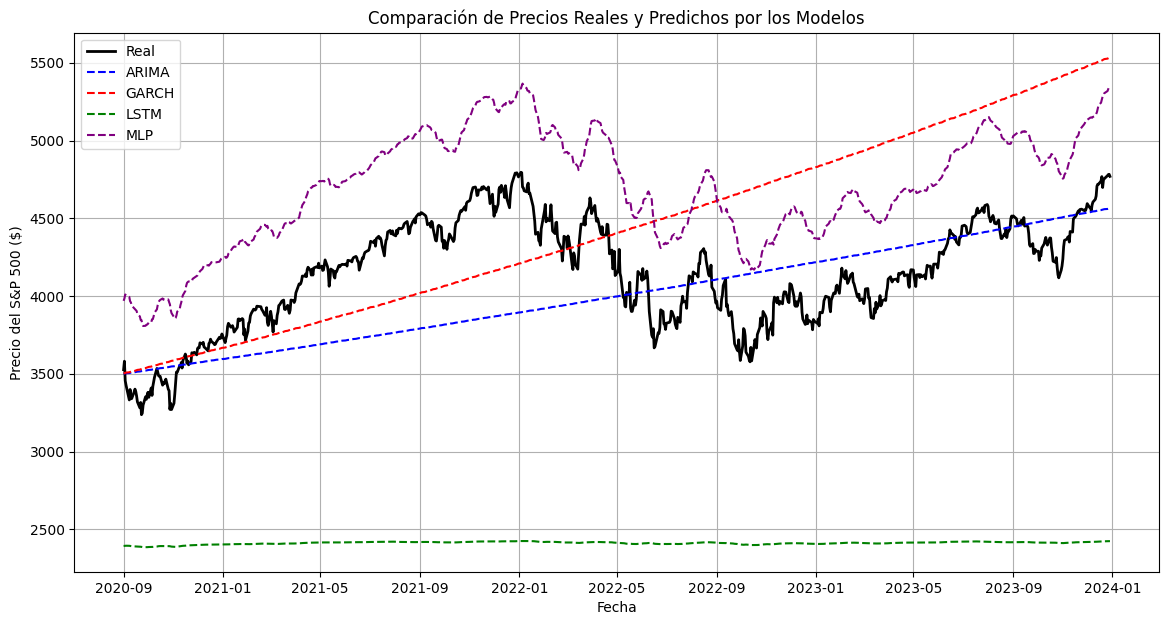

In [96]:
# Gráfico comparativo de precios
plt.figure(figsize=(14, 7))
plt.plot(comparison_prices_df['Fecha'], comparison_prices_df['Real'], label='Real', color='black', linewidth=2)
plt.plot(comparison_prices_df['Fecha'], comparison_prices_df['ARIMA'], label='ARIMA', color='blue', linestyle='--')
plt.plot(comparison_prices_df['Fecha'], comparison_prices_df['GARCH'], label='GARCH', color='red', linestyle='--')
plt.plot(comparison_prices_df['Fecha'], comparison_prices_df['LSTM'], label='LSTM', color='green', linestyle='--')
plt.plot(comparison_prices_df['Fecha'], comparison_prices_df['MLP'], label='MLP', color='purple', linestyle='--')
plt.title('Comparación de Precios Reales y Predichos por los Modelos')
plt.xlabel('Fecha')
plt.ylabel('Precio del S&P 500 ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Obtener los precios reales y las fechas correspondientes
prices_real_full = data['Price'].values
dates_full = data.index

# Definir los índices de inicio para los períodos de validación y prueba
validation_start_idx = train_size
test_start_idx = train_size + validation_size

# Concatenar las predicciones de validación y prueba
arima_pred_val_test = np.concatenate((arima_pred_validation, arima_pred_test))
